# 1 Data exploration and adaption

In [39]:
import pandas as pd
pd.set_option('display.max_columns', 500)
pd.set_option('display.float_format', lambda x: '%.3f' % x)
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics.regression import r2_score, mean_squared_error, mean_absolute_error
from math import sqrt
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima_model import ARIMA
from matplotlib.pylab import rcParams

def test_stationarity(timeseries):
    
    #Determine rolling statistics
    movingAverage = timeseries.rolling(window=12).mean()
    movingSTD = timeseries.rolling(window=12).std()
    
    #Plot rolling statistics
    orig = plt.plot(timeseries, color='cornflowerblue', label='Original')
    mean = plt.plot(movingAverage, color='red', label='Rolling Mean')
    std = plt.plot(movingSTD, color='black', label='Rolling Std')
    orig_p = plt.plot(timeseries, 'ok', markersize=2)
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)
    
    #Perform Dickey–Fuller test:
    print('Results of Dickey Fuller Test:')
    dftest = adfuller(timeseries['#Passengers'], autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)

In [3]:
data_file = "AirPassengers.csv"

df = pd.read_csv(data_file)
#Parse strings to datetime type
df['Month'] = pd.to_datetime(df['Month'],infer_datetime_format=True) #convert from string to datetime
indexeddf = df.set_index(['Month'])
display(indexeddf.head(5))

print(indexeddf.dtypes)
print("shape: " + str(indexeddf.shape))

,#Passengers
Month,
1949-01-01,112
1949-02-01,118
1949-03-01,132
1949-04-01,129
1949-05-01,121


#Passengers    int64
dtype: object
shape: (144, 1)


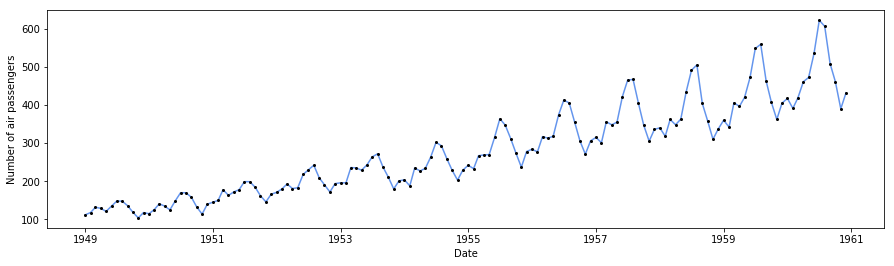

In [27]:
plt.figure(figsize=(15,4))
plt.xlabel('Date')
plt.ylabel('Number of air passengers')
plt.plot(indexeddf, linestyle='-', color='cornflowerblue')
plt.plot(indexeddf, 'ok', markersize=2)

In [28]:
# size = 12 (months) = yearly
rol_mean = indexedDataset.rolling(window=12).mean()
rol_std = indexedDataset.rolling(window=12).std()

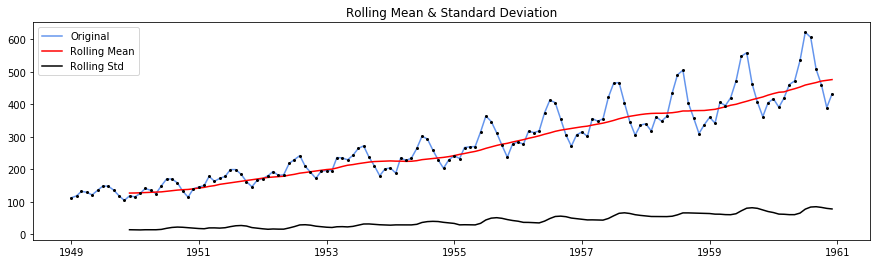

In [29]:
plt.figure(figsize=(15,4))
orig = plt.plot(indexeddf, color='cornflowerblue', label='Original')
mean = plt.plot(rol_mean, color='red', label='Rolling Mean')
std = plt.plot(rol_std, color='black', label='Rolling Std')
orig_p = plt.plot(indexeddf, 'ok', markersize=2)
plt.legend(loc='best')
plt.title('Rolling Mean & Standard Deviation')
plt.show(block=False)

&rarr; Time series is not stationary since rolling mean isn't parallel to x-axis. <br />
Confirmation:

In [33]:
#Perform Augmented Dickey–Fuller test:
print('Results of Dickey Fuller Test:')
dftest = adfuller(indexeddf['#Passengers'], autolag='AIC')

dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
for key,value in dftest[4].items():
    dfoutput['Critical Value (%s)'%key] = value
    
print(dfoutput)

Results of Dickey Fuller Test:
Test Statistic                  0.815
p-value                         0.992
#Lags Used                     13.000
Number of Observations Used   130.000
Critical Value (5%)            -2.884
Critical Value (1%)            -3.482
Critical Value (10%)           -2.579
dtype: float64


&rarr; p-value near max (=1.0), so definitely not stationary.

## 1.1 Data transformation to stationary

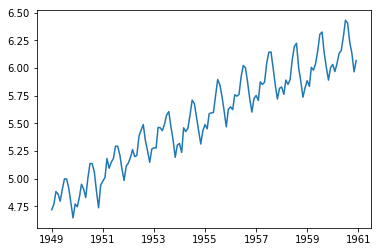

In [30]:
#Estimating trend
indexeddf_logScale = np.log(indexeddf)
plt.plot(indexeddf_logScale)

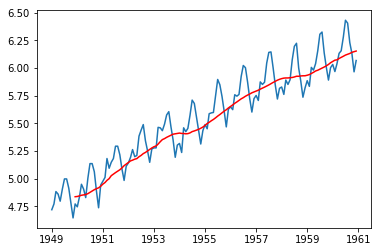

In [35]:
#The below transformation is required to make series stationary
movingAverage = indexeddf_logScale.rolling(window=12).mean()
movingSTD = indexeddf_logScale.rolling(window=12).std()
plt.plot(indexeddf_logScale)
plt.plot(movingAverage, color='red')

Subtracting two related series having similar trend components should make the result stationary.

In [37]:
datasetLogScaleMinusMovingAverage = indexeddf_logScale - movingAverage
display(datasetLogScaleMinusMovingAverage.head(12))

#Remove NAN values
datasetLogScaleMinusMovingAverage.dropna(inplace=True)
display(datasetLogScaleMinusMovingAverage.head(10))

,#Passengers
Month,
1949-01-01,nan
1949-02-01,nan
1949-03-01,nan
1949-04-01,nan
1949-05-01,nan
1949-06-01,nan
1949-07-01,nan
1949-08-01,nan
1949-09-01,nan


,#Passengers
Month,
1949-12-01,-0.065
1950-01-01,-0.093
1950-02-01,-0.008
1950-03-01,0.099
1950-04-01,0.052
1950-05-01,-0.028
1950-06-01,0.140
1950-07-01,0.260
1950-08-01,0.249


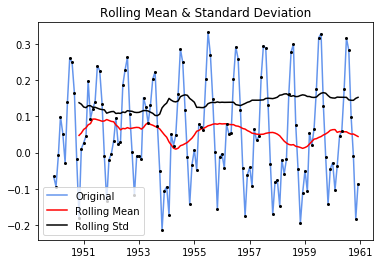

Results of Dickey Fuller Test:
Test Statistic                 -3.163
p-value                         0.022
#Lags Used                     13.000
Number of Observations Used   119.000
Critical Value (5%)            -2.886
Critical Value (1%)            -3.487
Critical Value (10%)           -2.580
dtype: float64


In [40]:
test_stationarity(datasetLogScaleMinusMovingAverage)

&rarr; p-value is now low enough for the time series to be considered stationary. We could also try out Exponential Decay Transformation and Time Shift Transformation, but log transformation will suffice for now. Another benefit of the log transformation is that we can easily revert the values to the original scale when making forecasts.

## 1.2 Break down components of log scale series

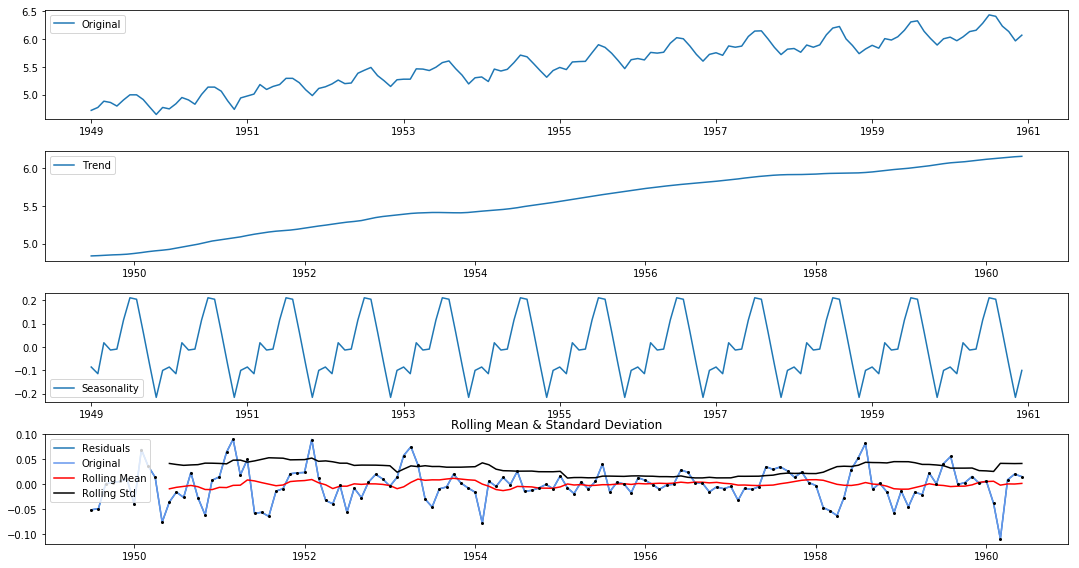

Results of Dickey Fuller Test:
Test Statistic                 -6.332
p-value                         0.000
#Lags Used                      9.000
Number of Observations Used   122.000
Critical Value (5%)            -2.886
Critical Value (1%)            -3.485
Critical Value (10%)           -2.580
dtype: float64


In [50]:
decomposition = seasonal_decompose(indexeddf_logScale) 

trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid


fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1, figsize=(15,8))

ax1.plot(indexeddf_logScale, label='Original')
ax1.legend(loc='best')

ax2.plot(trend, label='Trend')
ax2.legend(loc='best')

ax3.plot(seasonal, label='Seasonality')
ax3.legend(loc='best')

ax4.plot(residual, label='Residuals')
ax4.legend(loc='best')

plt.tight_layout()

#there can be cases where an observation simply consisted of trend & seasonality. In that case, there won't be 
#any residual component & that would be a null or NaN. Hence, we also remove such cases.
decomposedLogData = residual
decomposedLogData.dropna(inplace=True)


test_stationarity(decomposedLogData)